"Initiator or not?" Logistic Regression
===

- Number of journal updates
- Posting frequency (# updates / (last update - first update))
- Health condition
- Author role
- is_multisite_author
- is_mixed_site_author

is_interacted_with as  a separating factor

Not using: is_shared, due to its high correlation with author role

Feels like this is a propensity score matching problem?
Desired finding:
 - Level of activity is a strong predictor
 - Other features basically don't matter

Problem: comparing a group who may yet initiate to people who have already initiated.

One solution: Bucket people by their month of joining the site.  

The Q becomes: what differentiates people joining in the same month from initiating or not.

Take the average from the n "cohorts", look at the distribution of the coefficients. 
(Should be mostly normal-looking, centered on the mean)

#### From talking with Dan Kluver:

Argue: by using a time cutoff on the target feature, we enable the use of a simpler model.  However, we observe similar results with unbounded predictors (and note that only 11% of users who initiate do so later than the first year)

Dan: Explain the exploratory models, but then say what you present in the omnibus model.

Should really be using a zero-inflated model of some kind...

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
from stargazer.stargazer import Stargazer

In [4]:
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils

In [5]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_initiations"
assert os.path.exists(working_dir)

In [6]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [7]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
subset_start_date = datetime.fromisoformat('2014-01-01')
subset_start_timestamp = int(subset_start_date.timestamp() * 1000)

### Read in the data

In [8]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [9]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [10]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:16.692236


15850052

In [11]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
# note that only 41 updates have this issue
invalid_created_at = journal_df.created_at <= 0
journal_df.loc[invalid_created_at, 'created_at'] = journal_df.loc[invalid_created_at, 'updated_at']

In [12]:
health_cond_filepath = os.path.join("/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata", "assigned_health_conditions.feather")
user_health_conds_df = pd.read_feather(health_cond_filepath)
len(user_health_conds_df)

714874

In [13]:
# read the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

In [14]:
# read the user->user interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

14812407

In [15]:
# currently not necessary, since we use the processed user->user interactions...
# read in the interactions dataframe
#metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
#author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
#ints_df = pd.read_hdf(author_to_site)
#len(ints_df)

## Compute and merge the features

In [16]:
user_df = user_df[user_df.user_id.isin(valid_user_ids)]
len(user_df)

362345

In [17]:
user_df.head()

,user_id,patient_proportion,user_total,num_sites,user_author_type,is_shared
0,1,0.032086,187,1,cg,False
1,2,0.068966,29,1,cg,False
2,6,0.000000,17,1,cg,False
3,12,0.000000,15,1,cg,False
4,15,0.250000,12,1,cg,False


In [18]:
user_df['is_multisite_author'] = user_df.num_sites > 1
Counter(user_df.is_multisite_author).most_common()

[(False, 343654), (True, 18691)]

In [19]:
is_mixedsite_author_dict = {}
site_author_sets = journal_df[journal_df.user_id.isin(valid_user_ids)].groupby('site_id').agg({'user_id': lambda user_ids: set(user_ids)})
for site_id, user_ids in zip(site_author_sets.index, site_author_sets.user_id):
    if len(user_ids) > 1:
        for user_id in user_ids:
            is_mixedsite_author_dict[user_id] = True
is_mixedsite_author = [user_id in is_mixedsite_author_dict for user_id in user_df.user_id]
user_df['is_mixedsite_author'] = is_mixedsite_author
# 21.8% of authors have written updates on a site on which another valid author has written an update 
np.sum(is_mixedsite_author), np.sum(is_mixedsite_author) / len(is_mixedsite_author)

(79115, 0.2183416357339)

In [20]:
# merge in the health condition data
user_health_cond_dict = {user_id: assigned_health_cond for user_id, assigned_health_cond in zip(user_health_conds_df.user_id, user_health_conds_df.assigned_health_cond)}
health_condition = [user_health_cond_dict[user_id] for user_id in user_df.user_id]
user_df['health_condition'] = health_condition

In [21]:
# number of journal updates, first update, last update
user_updates_df = journal_df[journal_df.user_id.isin(valid_user_ids)].groupby('user_id').agg({
    'journal_oid': lambda group: len(group),
    'created_at': lambda created_ats: (np.min(created_ats), np.max(created_ats))
}).reset_index()  # note that columns are not renamed appropriately, but are reused immediately
user_update_count_dict = {
    user_id: count for user_id, count 
    in zip(user_updates_df.user_id, user_updates_df.journal_oid)}
user_first_update_dict = {
    user_id: created_at[0] for user_id, created_at 
    in zip(user_updates_df.user_id, user_updates_df.created_at)}
user_last_update_dict = {
    user_id: created_at[1] for user_id, created_at 
    in zip(user_updates_df.user_id, user_updates_df.created_at)}
update_count = [user_update_count_dict[user_id] for user_id in user_df.user_id]
first_update = [user_first_update_dict[user_id] for user_id in user_df.user_id]
last_update = [user_last_update_dict[user_id] for user_id in user_df.user_id]
user_df['update_count'] = update_count
user_df['first_update'] = first_update
user_df['last_update'] = last_update
user_df['author_tenure'] = user_df.last_update - user_df.first_update
assert np.all(user_df.author_tenure > 0)

In [22]:
# posting frequency (updates per month, across all sites)
tenure_in_months = user_df.author_tenure / (1000 * 60 * 60 * 24 * 30)
user_df['update_frequency'] = user_df.update_count / tenure_in_months

In [23]:
# one small detail is that only 63% of users have the same update count and user total
# I speculate that the user_total eliminates updates on non-valid sites, while the update_count includes these updates
np.sum(user_df.update_count == user_df.user_total) / len(user_df)

0.6297754902096069

In [24]:
# is_interacted_with
# computed from the user->user interaction data
interacted_with_user_ids = set(u2u_df.to_user_id)
is_interacted_with = [user_id in interacted_with_user_ids for user_id in user_df.user_id]
user_df['is_interacted_with'] = is_interacted_with

In [25]:
np.sum(is_interacted_with), np.sum(is_interacted_with) / len(is_interacted_with)

(209141, 0.577187487063434)

In [26]:
# the primary outcome in this analysis
initiating_user_ids = set(u2u_df.from_user_id)
is_initiator = [user_id in initiating_user_ids for user_id in user_df.user_id]
user_df['is_initiator'] = is_initiator

In [27]:
np.sum(is_initiator), np.sum(is_initiator) / len(is_initiator)

(207534, 0.572752487270419)

#### Construct time-bound outcomes

In [28]:
ms_1yr = 1000 * 60 * 60 * 24 * 365
first_update_dict = {user_id: first_update for user_id, first_update in zip(user_df.user_id, user_df.first_update)}

In [29]:
u2u_subset = u2u_df[u2u_df.from_user_id.isin(set(first_update_dict.keys()))]
users_initiating_within_1yr = set([from_user_id 
                                  for from_user_id, created_at 
                                  in zip(u2u_subset.from_user_id, u2u_subset.created_at) 
                                  if created_at <= first_update_dict[from_user_id] + ms_1yr])
is_initiator_1yr = [user_id in users_initiating_within_1yr for user_id in user_df.user_id]

In [30]:
u2u_subset = u2u_df[u2u_df.to_user_id.isin(set(first_update_dict.keys()))]
users_with_ints_within_1yr = set([to_user_id 
                                  for to_user_id, created_at 
                                  in zip(u2u_subset.to_user_id, u2u_subset.created_at) 
                                  if created_at <= first_update_dict[to_user_id] + ms_1yr])
is_interacted_with_1yr = [user_id in users_with_ints_within_1yr for user_id in user_df.user_id]

In [31]:
user_df['is_interacted_with_1yr'] = is_interacted_with_1yr
user_df['is_initiator_1yr'] = is_initiator_1yr

In [32]:
# what % of authors initiate more than 1 year from their first update?
np.sum((user_df.is_initiator)&(~user_df.is_initiator_1yr)) / len(user_df)

0.11685824283486733

In [33]:
# what % of authors are interacted with more than 1 year from their first update?
np.sum((user_df.is_interacted_with)&(~user_df.is_interacted_with_1yr)) / len(user_df)

0.023546619934040763

### Construct cohort

In [34]:
def get_year_month(first_update):
    date = datetime.utcfromtimestamp(first_update / 1000)
    return date.strftime('%Y-%m')
    
first_update_month = user_df.first_update.map(get_year_month)
user_df['first_update_month'] = first_update_month

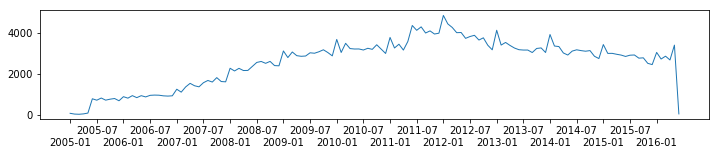

In [35]:
# confirm that the number of users in each cohort is somewhat consistent
first_update_months = user_df[(user_df.first_update >= start_timestamp)&(user_df.first_update <= end_timestamp)].first_update_month
fig, ax = plt.subplots(1, 1, figsize=(12,2))
xs = sorted(set(first_update_months))
counts = Counter(first_update_months)
ys = [counts[x] for x in xs]
plt.plot(xs, ys, linestyle='-', linewidth=1, label='Initiations')

newline = '\n'
xticks = xs[::6]
plt.xticks(xticks, [f"{newline if i%2 == 0 else ''}{xtick}" for i, xtick in enumerate(xticks)])

plt.show()

## Construct the user subset and fit the models

In [36]:
model_start_date = datetime.fromisoformat('2014-01-01')
model_start_timestamp = int(model_start_date.timestamp() * 1000)
model_end_date = datetime.fromisoformat('2016-01-01')
model_end_timestamp = int(model_end_date.timestamp() * 1000)

In [37]:
# convert all boolean columns to integers
cols_to_convert = []
for column, dtype in zip(user_df.columns, user_df.dtypes):
    if dtype == "bool":
        cols_to_convert.append(column)
for column in cols_to_convert:
    user_df[column] = user_df[column].astype(int)
user_df.dtypes

user_id                     int64
patient_proportion        float64
user_total                  int64
num_sites                   int64
user_author_type           object
is_shared                   int64
is_multisite_author         int64
is_mixedsite_author         int64
health_condition           object
update_count                int64
first_update                int64
last_update                 int64
author_tenure               int64
update_frequency          float64
is_interacted_with          int64
is_initiator                int64
is_interacted_with_1yr      int64
is_initiator_1yr            int64
first_update_month         object
dtype: object

In [38]:
# we can't know if an author initiated or was interacted with after this timestamp
# so to define a "interacted with within X time" feature, the author's first update needs to be less than this time
last_interaction_observed = np.max(u2u_df[u2u_df.int_type == 'guestbook'].created_at)
datetime.utcfromtimestamp(last_interaction_observed / 1000)

datetime.datetime(2016, 6, 1, 21, 7, 43)

In [39]:
#user_subset = user_df[(user_df.first_update >= model_start_timestamp)&(user_df.first_update <= model_end_timestamp)]
user_subset = user_df[(user_df.first_update >= model_start_timestamp)&(user_df.first_update <= model_end_timestamp)&(user_df.first_update + ms_1yr <= last_interaction_observed)]
test_user_subset = user_df[user_df.first_update > model_end_timestamp]
len(user_subset), len(user_subset) / len(user_df)

(53335, 0.14719397259517863)

In [40]:
Counter(user_subset.health_condition).most_common()

[('None', 31771),
 ('Cancer', 13766),
 ('Cardiovascular/Stroke', 1964),
 ('Surgery/Transplantation', 1468),
 ('Injury', 1420),
 ('Neurological Condition', 1106),
 ('Infant/Childbirth', 798),
 ('Other', 707),
 ('Congenital/Immune Disorder', 334),
 ('Condition Unknown', 1)]

In [41]:
# remap the singleton Condition Unknown user to "Other"
user_subset.loc[user_subset.health_condition == 'Condition Unknown', 'health_condition'] = 'Other'

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [42]:
Counter(user_subset.user_author_type).most_common()

[('cg', 40416), ('p', 9795), ('mixed', 3124)]

In [43]:
# is_multisite_author X is_initiator contingency table
# made to debug an issue with quasi-perfect separation
cont_table = np.zeros((2,2))
for is_multisite_author, is_initiator in zip(user_subset.is_multisite_author, user_subset.is_initiator):
    assert is_multisite_author == 0 or is_multisite_author == 1
    assert is_initiator == 0 or is_initiator == 1
    cont_table[is_multisite_author,is_initiator] += 1            
cont_table

array([[24823., 25986.],
       [ 1135.,  1391.]])

In [44]:
user_subset[["is_initiator", "is_initiator_1yr", "is_interacted_with", "is_interacted_with_1yr", "update_count", "update_frequency", "is_mixedsite_author", "num_sites", "is_multisite_author"]].corr()

,is_initiator,is_initiator_1yr,is_interacted_with,is_interacted_with_1yr,update_count,update_frequency,is_mixedsite_author,num_sites,is_multisite_author
is_initiator,1.000000,0.849891,0.298587,0.292615,0.105193,-0.104995,0.028630,0.004147,0.016671
is_initiator_1yr,0.849891,1.000000,0.287198,0.284565,0.091816,-0.091186,0.018832,0.002579,0.012251
is_interacted_with,0.298587,0.287198,1.000000,0.979782,0.129917,-0.107929,0.170247,-0.011793,-0.000158
is_interacted_with_1yr,0.292615,0.284565,0.979782,1.000000,0.119569,-0.097753,0.165892,-0.035773,-0.027513
update_count,0.105193,0.091816,0.129917,0.119569,1.000000,-0.022960,-0.056948,0.044440,0.035505
update_frequency,-0.104995,-0.091186,-0.107929,-0.097753,-0.022960,1.000000,-0.045376,-0.057254,-0.064307
is_mixedsite_author,0.028630,0.018832,0.170247,0.165892,-0.056948,-0.045376,1.000000,0.002930,0.012872
num_sites,0.004147,0.002579,-0.011793,-0.035773,0.044440,-0.057254,0.002930,1.000000,0.864776
is_multisite_author,0.016671,0.012251,-0.000158,-0.027513,0.035505,-0.064307,0.012872,0.864776,1.000000


In [45]:
def print_feature_summary(res):
    for feature, coef in zip(res.params.index, res.params):
        prob = np.exp(coef)/(1+np.exp(coef))
        feature_name = feature
        if "health_condition" in feature_name:
            feature_name = "health_condition " + feature_name.split("[")[1][2:-1]
        print(f"{feature_name:<50} {min((np.exp(coef)-1)*100, 999):>8.3f}% increase   {prob*100:>8.2f}%   ({np.exp(coef):.3f})")

#### Omnibus model, no removals

In [46]:
formula = """
is_initiator_1yr ~ 
    is_interacted_with_1yr 
    + user_author_type
    + user_author_type * is_interacted_with_1yr
    + update_count 
    + update_frequency 
    + is_mixedsite_author
    + C(health_condition, Treatment(reference='None'))
    + is_multisite_author
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.logit(formula=formula, 
                  data=user_subset)
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 0.635522
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_initiator_1yr   No. Observations:                53335
Model:                          Logit   Df Residuals:                    53317
Method:                           MLE   Df Model:                           17
Date:                Sun, 05 Jan 2020   Pseudo R-squ.:                 0.07085
Time:                        13:42:54   Log-Likelihood:                -33896.
converged:                       True   LL-Null:                       -36480.
                                        LLR p-value:                     0.000
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         -0.8080      0.021    -38.848      0.000      -0.849      -0.767
user_author_type[T.mixed]                                                         -0.3447      0.064     -5.391      0.000      -0.470      -0.219
user_author_type[T.p]                                                             -0.3939      0.040     -9.876      0.000      -0.472      -0.316
C(health_condition, Treatment(reference='None'))[T.Cancer]                         0.1065      0.022      4.777      0.000       0.063       0.150
C(health_condition, Treatment(reference='None'))[T.Cardiovascular/Stroke]          0.0594      0.049      1.205      0.228      -0.037       0.156
C(health_condition, Treatment(reference='None'))[T.Congenital/Immune Disorder]     0.0630      0.116      0.544      0.587      -0.164       0.290
C(health_condition, Treatment(reference='None'))[T.Infant/Childbirth]             -0.1540      0.076     -2.024      0.043      -0.303      -0.005
C(health_condition, Treatment(reference='None'))[T.Injury]                        -0.1569      0.058     -2.709      0.007      -0.270      -0.043
C(health_condition, Treatment(reference='None'))[T.Neurological Condition]         0.3008      0.064      4.688      0.000       0.175       0.427
C(health_condition, Treatment(reference='None'))[T.Other]                          0.1109      0.080      1.380      0.168      -0.047       0.269
C(health_condition, Treatment(reference='None'))[T.Surgery/Transplantation]        0.0629      0.057      1.104      0.269      -0.049       0.174
is_interacted_with_1yr                                                             1.0372      0.022     47.873      0.000       0.995       1.080
user_author_type[T.mixed]:is_interacted_with_1yr                                   0.4136      0.082      5.029      0.000       0.252       0.575
user_author_type[T.p]:is_interacted_with_1yr                                       0.6051      0.050     12.035      0.000       0.507       0.704
update_count                                                                       0.0029      0.000     12.014      0.000       0.002       0.003
update_frequency                                                                  -0.0084      0.001    -14.671      0.000      -0.010      -0.007
is_mixedsite_author                                                               -0.1368      0.020     -6.899      0.000      -0.176      -0.098
is_multisite_author                                                                0.1338      0.043      3.094      0.002       0.049       0.219
==================================================================================================================================================
"""

In [47]:
print_feature_summary(res)

Intercept                                           -55.426% increase      30.83%   (-0.808)
user_author_type[T.mixed]                           -29.157% increase      41.47%   (-0.345)
user_author_type[T.p]                               -32.555% increase      40.28%   (-0.394)
health_condition Cancer                              11.232% increase      52.66%   (0.106)
health_condition Cardiovascular/Stroke                6.116% increase      51.48%   (0.059)
health_condition Congenital/Immune Disorder           6.502% increase      51.57%   (0.063)
health_condition Infant/Childbirth                  -14.275% increase      46.16%   (-0.154)
health_condition Injury                             -14.520% increase      46.09%   (-0.157)
health_condition Neurological Condition              35.094% increase      57.46%   (0.301)
health_condition Other                               11.731% increase      52.77%   (0.111)
health_condition Surgery/Transplantation              6.489% increase      

In [48]:
# Testing on the last 6 months of users, we predict initiators with 67% accuracy
raw_preds = res.predict(test_user_subset)
preds = raw_preds >= 0.5
acc = np.sum(preds == test_user_subset.is_initiator) / len(test_user_subset)
acc, Counter(preds).most_common()

(0.67704022512829, [(False, 10621), (True, 7502)])

In [48]:
# Training set accuracy, for curiosity
raw_preds = res.predict(user_subset)
preds = raw_preds >= 0.5
acc = np.sum(preds == user_subset.is_initiator) / len(user_subset)
acc

0.6455610762163683

In [49]:
np.sum(user_subset.is_initiator_1yr == 1) / len(user_subset)

0.43239898753163963

In [50]:
np.sum(user_subset.is_interacted_with_1yr == 1) / len(user_subset)

0.541295584512984

In [51]:
# 33% of authors neither interact nor are interacted with (within 1 year)
np.sum((user_subset.is_interacted_with_1yr == 0)&(user_subset.is_initiator_1yr == 0)) / len(user_subset)

0.3306084184869223

#### Broken down by `is_interacted_with`

Including fitting a model with an author_type X is_interacted_with interaction term.

In [133]:
formula = """
is_initiator_1yr ~ 
    user_author_type
    + update_count 
    + update_frequency 
    + is_mixedsite_author
    + C(health_condition, Treatment(reference='None'))
    + is_multisite_author
    + 1
"""
full = user_subset
is_interacted_with_subset = user_subset[user_subset.is_interacted_with_1yr == 1]
not_interacted_with_subset = user_subset[user_subset.is_interacted_with_1yr == 0]
full_model = smf.logit(formula=formula, #+ " + is_interacted_with_1yr", 
                  data=full)
is_model = smf.logit(formula=formula, 
                  data=is_interacted_with_subset)
not_model = smf.logit(formula=formula, 
                  data=not_interacted_with_subset)
full_res = full_model.fit()
is_res = is_model.fit()
not_res = not_model.fit()

Optimization terminated successfully.
         Current function value: 0.637049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588231
         Iterations 5


In [135]:
mds = [full_res, is_res, not_res]
for i, param in enumerate(mds[1].params.index):
    if "health_condition" in param:
        param = param.split("T.")[1]
    param = param.replace("_", "-")
    coefs_strs = []
    se_strs = []
    for md in mds:
        c = md.params.iloc[i]
        coef_str = f"{c:>6.3f}"
        se = md.bse.iloc[i]
        se_strs.append(f"({se:.3f})")
        p_val = md.pvalues.iloc[i]
        pval_str = ""
        if p_val <= 0.05:
            pval_str = "*"
        elif p_val <= 0.01:
            pval_str = "**"
        else:
            pval_str = "***"
        coef_str += "$^{" + pval_str + "}$"
        coefs_strs.append(coef_str)
    print(f"{param} & " + " & ".join(coefs_strs) + " \\\\")
    print(f" & " + " & ".join(se_strs) + " \\\\")

Intercept & -0.882$^{*}$ &  0.242$^{*}$ & -0.845$^{*}$ \\
 & (0.020) & (0.025) & (0.026) \\
user-author-type[T.mixed] & -0.100$^{*}$ &  0.048$^{***}$ & -0.311$^{*}$ \\
 & (0.040) & (0.052) & (0.064) \\
user-author-type[T.p] & -0.028$^{***}$ &  0.189$^{*}$ & -0.357$^{*}$ \\
 & (0.024) & (0.032) & (0.040) \\
Cancer] &  0.105$^{*}$ &  0.098$^{*}$ &  0.108$^{*}$ \\
 & (0.022) & (0.029) & (0.036) \\
Cardiovascular/Stroke] &  0.059$^{***}$ &  0.071$^{***}$ &  0.040$^{***}$ \\
 & (0.050) & (0.065) & (0.077) \\
Congenital/Immune Disorder] &  0.035$^{***}$ &  0.135$^{***}$ & -0.067$^{***}$ \\
 & (0.116) & (0.146) & (0.200) \\
Infant/Childbirth] & -0.162$^{*}$ & -0.026$^{***}$ & -0.455$^{*}$ \\
 & (0.076) & (0.095) & (0.141) \\
Injury] & -0.166$^{*}$ & -0.221$^{*}$ & -0.056$^{***}$ \\
 & (0.058) & (0.071) & (0.097) \\
Neurological Condition] &  0.298$^{*}$ &  0.174$^{*}$ &  0.466$^{*}$ \\
 & (0.064) & (0.086) & (0.093) \\
Other] &  0.114$^{***}$ &  0.042$^{***}$ &  0.190$^{***}$ \\
 & (0.081) & 

In [51]:
(np.exp(0.137) - 1) * 100

14.682814852039815

In [130]:
# Test set accuracies
test_subsets =[
    test_user_subset,
    test_user_subset[test_user_subset.is_interacted_with_1yr == 1],
    test_user_subset[test_user_subset.is_interacted_with_1yr == 0],
]
accs = []
for md, test_ss in zip(mds,  test_subsets):
    raw_preds = md.predict(test_ss)
    preds = raw_preds >= 0.5
    acc = np.sum(preds == test_ss.is_initiator) / len(test_ss)
    accs.append(f"{acc*100:.2f}\\%")
print(" & ".join(accs))

58.99\% & 60.95\% & 73.23\%


In [128]:
# log likelihood and num of observations
print(" & ".join([f"{md.llf:.3f}" for md in mds])) 
print(" & ".join([f"{md.nobs}" for md in mds]))

-35923.278 & -19434.315 & -14391.070
53335 & 28870 & 24465


In [80]:
is_res.rsquared = 0.5
not_res.rsquared = 0.5
is_res.rsquared_adj = 0.5
not_res.rsquared_adj = 0.5
is_res.fvalue = 0.5
not_res.fvalue = 0.5
is_res.f_pvalue = 0.5
not_res.f_pvalue = 0.5

full_res.rsquared = 0.5
full_res.rsquared_adj = 0.5
full_res.fvalue = 0.5
full_res.f_pvalue = 0.5
#print(Stargazer([full_res, is_res, not_res]).render_latex())

In [53]:
print_feature_summary(is_res)
is_res.summary()

Intercept                                            27.380% increase      56.02%   (0.242)
user_author_type[T.mixed]                             4.933% increase      51.20%   (0.048)
user_author_type[T.p]                                20.857% increase      54.72%   (0.189)
health_condition Cancer                              10.250% increase      52.44%   (0.098)
health_condition Cardiovascular/Stroke                7.364% increase      51.78%   (0.071)
health_condition Congenital/Immune Disorder          14.412% increase      53.36%   (0.135)
health_condition Infant/Childbirth                   -2.585% increase      49.35%   (-0.026)
health_condition Injury                             -19.858% increase      44.49%   (-0.221)
health_condition Neurological Condition              18.999% increase      54.34%   (0.174)
health_condition Other                                4.279% increase      51.05%   (0.042)
health_condition Surgery/Transplantation             11.594% increase      52.

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_initiator_1yr   No. Observations:                28870
Model:                          Logit   Df Residuals:                    28855
Method:                           MLE   Df Model:                           14
Date:                Sat, 28 Dec 2019   Pseudo R-squ.:                 0.01784
Time:                        15:26:08   Log-Likelihood:                -19434.
converged:                       True   LL-Null:                       -19787.
                                        LLR p-value:                1.279e-141
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          0.2420      0.025      9.856      0.000       0.194       0.290
user_author_type[T.mixed]                                                          0.0481      0.052      0.921      0.357      -0.054       0.151
user_author_type[T.p]                                                              0.1894      0.032      5.887      0.000       0.126       0.253
C(health_condition, Treatment(reference='None'))[T.Cancer]                         0.0976      0.029      3.400      0.001       0.041       0.154
C(health_condition, Treatment(reference='None'))[T.Cardiovascular/Stroke]          0.0711      0.065      1.100      0.271      -0.056       0.198
C(health_condition, Treatment(reference='None'))[T.Congenital/Immune Disorder]     0.1346      0.146      0.924      0.355      -0.151       0.420
C(health_condition, Treatment(reference='None'))[T.Infant/Childbirth]             -0.0262      0.095     -0.277      0.782      -0.212       0.159
C(health_condition, Treatment(reference='None'))[T.Injury]                        -0.2214      0.071     -3.098      0.002      -0.361      -0.081
C(health_condition, Treatment(reference='None'))[T.Neurological Condition]         0.1739      0.086      2.026      0.043       0.006       0.342
C(health_condition, Treatment(reference='None'))[T.Other]                          0.0419      0.108      0.387      0.699      -0.170       0.254
C(health_condition, Treatment(reference='None'))[T.Surgery/Transplantation]        0.1097      0.076      1.449      0.147      -0.039       0.258
update_count                                                                       0.0044      0.000     12.899      0.000       0.004       0.005
update_frequency                                                                  -0.0103      0.001    -12.760      0.000      -0.012      -0.009
is_mixedsite_author                                                               -0.2105      0.025     -8.430      0.000      -0.259      -0.162
is_multisite_author                                                                0.2747      0.062      4.423      0.000       0.153       0.396
==================================================================================================================================================
"""

In [54]:
print_feature_summary(not_res)
not_res.summary()

Intercept                                           -57.047% increase      30.05%   (-0.845)
user_author_type[T.mixed]                           -26.758% increase      42.28%   (-0.311)
user_author_type[T.p]                               -30.032% increase      41.17%   (-0.357)
health_condition Cancer                              11.376% increase      52.69%   (0.108)
health_condition Cardiovascular/Stroke                4.114% increase      51.01%   (0.040)
health_condition Congenital/Immune Disorder          -6.461% increase      48.33%   (-0.067)
health_condition Infant/Childbirth                  -36.547% increase      38.82%   (-0.455)
health_condition Injury                              -5.444% increase      48.60%   (-0.056)
health_condition Neurological Condition              59.319% increase      61.44%   (0.466)
health_condition Other                               20.876% increase      54.73%   (0.190)
health_condition Surgery/Transplantation             -1.217% increase     

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_initiator_1yr   No. Observations:                24465
Model:                          Logit   Df Residuals:                    24450
Method:                           MLE   Df Model:                           14
Date:                Sat, 28 Dec 2019   Pseudo R-squ.:                0.006785
Time:                        15:26:11   Log-Likelihood:                -14391.
converged:                       True   LL-Null:                       -14489.
                                        LLR p-value:                 2.690e-34
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         -0.8451      0.026    -33.011      0.000      -0.895      -0.795
user_author_type[T.mixed]                                                         -0.3114      0.064     -4.879      0.000      -0.436      -0.186
user_author_type[T.p]                                                             -0.3571      0.040     -8.842      0.000      -0.436      -0.278
C(health_condition, Treatment(reference='None'))[T.Cancer]                         0.1077      0.036      3.033      0.002       0.038       0.177
C(health_condition, Treatment(reference='None'))[T.Cardiovascular/Stroke]          0.0403      0.077      0.527      0.598      -0.110       0.190
C(health_condition, Treatment(reference='None'))[T.Congenital/Immune Disorder]    -0.0668      0.200     -0.333      0.739      -0.459       0.326
C(health_condition, Treatment(reference='None'))[T.Infant/Childbirth]             -0.4549      0.141     -3.223      0.001      -0.731      -0.178
C(health_condition, Treatment(reference='None'))[T.Injury]                        -0.0560      0.097     -0.576      0.565      -0.247       0.135
C(health_condition, Treatment(reference='None'))[T.Neurological Condition]         0.4657      0.093      4.988      0.000       0.283       0.649
C(health_condition, Treatment(reference='None'))[T.Other]                          0.1896      0.118      1.611      0.107      -0.041       0.420
C(health_condition, Treatment(reference='None'))[T.Surgery/Transplantation]       -0.0122      0.088     -0.139      0.889      -0.185       0.160
update_count                                                                       0.0008      0.000      2.464      0.014       0.000       0.001
update_frequency                                                                  -0.0058      0.001     -7.315      0.000      -0.007      -0.004
is_mixedsite_author                                                                0.0144      0.033      0.443      0.658      -0.049       0.078
is_multisite_author                                                                0.0119      0.063      0.188      0.851      -0.112       0.136
==================================================================================================================================================
"""

In [131]:
formula = """
is_initiator_1yr ~  
    user_author_type * is_interacted_with
    + 1
"""
model = smf.logit(formula=formula, 
                  data=user_subset)
res = model.fit(maxiter=100)

print_feature_summary(res)

raw_preds = res.predict(test_user_subset)
preds = raw_preds >= 0.5
acc = np.sum(preds == test_user_subset.is_initiator) / len(test_user_subset)
print(f"Test Accuracy: {acc*100:.2f}%")
raw_preds = res.predict(user_subset)
preds = raw_preds >= 0.5
acc = np.sum(preds == user_subset.is_initiator) / len(user_subset)
print(f"Train Accuracy: {acc*100:.2f}%")

res.summary()

Optimization terminated successfully.
         Current function value: 0.640240
         Iterations 5
Intercept                                           -59.541% increase      28.81%   (-0.905)
user_author_type[T.mixed]                           -25.762% increase      42.61%   (-0.298)
user_author_type[T.p]                               -25.638% increase      42.65%   (-0.296)
is_interacted_with                                  196.137% increase      74.76%   (1.086)
user_author_type[T.mixed]:is_interacted_with         54.584% increase      60.72%   (0.436)
user_author_type[T.p]:is_interacted_with             80.974% increase      64.41%   (0.593)
Test Accuracy: 67.89%
Train Accuracy: 64.98%


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_initiator_1yr   No. Observations:                53335
Model:                          Logit   Df Residuals:                    53329
Method:                           MLE   Df Model:                            5
Date:                Sat, 28 Dec 2019   Pseudo R-squ.:                 0.06395
Time:                        16:48:48   Log-Likelihood:                -34147.
converged:                       True   LL-Null:                       -36480.
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.9049      0.016    -55.411      0.000      -0.937      -0.873
user_author_type[T.mixed]                       -0.2979      0.065     -4.599      0.000      -0.425      -0.171
user_author_type[T.p]                           -0.2962      0.040     -7.397      0.000      -0.375      -0.218
is_interacted_with                               1.0857      0.021     51.241      0.000       1.044       1.127
user_author_type[T.mixed]:is_interacted_with     0.4356      0.082      5.281      0.000       0.274       0.597
user_author_type[T.p]:is_interacted_with         0.5932      0.050     11.762      0.000       0.494       0.692
================================================================================================================
"""

In [49]:
np.exp( 0.5932)

1.8097704246078856

In [132]:
print(res.summary2().as_latex())

\begin{table}
\caption{Results: Logit}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & Logit            & Pseudo R-squared: & 0.064       \\
Dependent Variable: & is_initiator_1yr & AIC:              & 68306.4489  \\
Date:               & 2019-12-28 16:52 & BIC:              & 68359.7550  \\
No. Observations:   & 53335            & Log-Likelihood:   & -34147.     \\
Df Model:           & 5                & LL-Null:          & -36480.     \\
Df Residuals:       & 53329            & LLR p-value:      & 0.0000      \\
Converged:          & 1.0000           & Scale:            & 1.0000      \\
No. Iterations:     & 5.0000           &                   &             \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                 &  Coef.  & Std.Err. &    z     & P$>$$|$z$|$ &  [0.025 &  0.975]  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                        

#### Predicting `is_interacted_with` rather than `is_initiator`

In [56]:
formula = """
is_interacted_with_1yr ~ 
    is_initiator_1yr
    + user_author_type
    + update_count 
    + update_frequency 
    + is_mixedsite_author
    + C(health_condition, Treatment(reference='None'))
    + is_multisite_author
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.logit(formula=formula, 
                  data=user_subset)
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 0.621222
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     is_interacted_with_1yr   No. Observations:                53335
Model:                              Logit   Df Residuals:                    53319
Method:                               MLE   Df Model:                           15
Date:                    Sat, 28 Dec 2019   Pseudo R-squ.:                 0.09933
Time:                            15:26:27   Log-Likelihood:                -33133.
converged:                           True   LL-Null:                       -36787.
                                            LLR p-value:                     0.000
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         -0.7014      0.020    -34.974      0.000      -0.741      -0.662
user_author_type[T.mixed]                                                         -0.0177      0.040     -0.441      0.659      -0.096       0.061
user_author_type[T.p]                                                              0.0177      0.025      0.706      0.480      -0.031       0.067
C(health_condition, Treatment(reference='None'))[T.Cancer]                         0.0005      0.023      0.023      0.982      -0.044       0.045
C(health_condition, Treatment(reference='None'))[T.Cardiovascular/Stroke]         -0.0510      0.050     -1.016      0.310      -0.149       0.047
C(health_condition, Treatment(reference='None'))[T.Congenital/Immune Disorder]     0.2195      0.121      1.821      0.069      -0.017       0.456
C(health_condition, Treatment(reference='None'))[T.Infant/Childbirth]              0.2212      0.078      2.824      0.005       0.068       0.375
C(health_condition, Treatment(reference='None'))[T.Injury]                         0.2017      0.059      3.394      0.001       0.085       0.318
C(health_condition, Treatment(reference='None'))[T.Neurological Condition]        -0.1325      0.066     -2.011      0.044      -0.262      -0.003
C(health_condition, Treatment(reference='None'))[T.Other]                         -0.1626      0.082     -1.994      0.046      -0.322      -0.003
C(health_condition, Treatment(reference='None'))[T.Surgery/Transplantation]       -0.1125      0.057     -1.962      0.050      -0.225   -9.24e-05
is_initiator_1yr                                                                   1.1521      0.019     60.096      0.000       1.115       1.190
update_count                                                                       0.0094      0.000     26.711      0.000       0.009       0.010
update_frequency                                                                  -0.0075      0.001    -13.837      0.000      -0.009      -0.006
is_mixedsite_author                                                                0.8029      0.020     39.692      0.000       0.763       0.843
is_multisite_author                                                               -0.4737      0.045    -10.554      0.000      -0.562      -0.386
==================================================================================================================================================
"""

In [57]:
print_feature_summary(res)

Intercept                                           -50.413% increase      33.15%   (-0.701)
user_author_type[T.mixed]                            -1.753% increase      49.56%   (-0.018)
user_author_type[T.p]                                 1.782% increase      50.44%   (0.018)
health_condition Cancer                               0.052% increase      50.01%   (0.001)
health_condition Cardiovascular/Stroke               -4.973% increase      48.72%   (-0.051)
health_condition Congenital/Immune Disorder          24.545% increase      55.47%   (0.219)
health_condition Infant/Childbirth                   24.752% increase      55.51%   (0.221)
health_condition Injury                              22.342% increase      55.02%   (0.202)
health_condition Neurological Condition             -12.411% increase      46.69%   (-0.133)
health_condition Other                              -15.011% increase      45.94%   (-0.163)
health_condition Surgery/Transplantation            -10.639% increase      

#### Fitting separate models for each cohort

In [180]:
cohorts = sorted([c for c, count in Counter(user_subset.first_update_month).most_common() if count >= 1000])

formula = """
is_initiator ~ 
    is_interacted_with
    + user_author_type
    + update_count 
    + update_frequency 
    + is_mixedsite_author
    + is_multisite_author
    + 1
"""
formula= """
is_initiator ~ 
    user_author_type * is_interacted_with
    + 1
"""

results = []
for cohort in cohorts:
    model_data = user_subset[user_subset.first_update_month == cohort]
    model = smf.logit(formula=formula, 
                  data=model_data)
    res = model.fit()
    results.append(res)

Optimization terminated successfully.
         Current function value: 0.651861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642909
  

In [181]:
params = []
for result in results:
    params.append(result.params)
params = np.array(params)

In [183]:
for feature, coef, std in zip(results[0].params.index, params.mean(axis=0), params.std(axis=0)):
    prob = np.exp(coef)/(1+np.exp(coef))
    feature_name = feature
    if "health_condition" in feature_name:
        feature_name = "health_condition " + feature_name.split("[")[1][2:-1]
    print(f"{feature_name:<50} {min((np.exp(coef)-1)*100, 999):>8.3f}% increase   {prob*100:>8.2f}%   ({coef:.3f} std {std:.3f})")

Intercept                                           -45.669% increase      35.20%   (-0.610 std 0.091)
user_author_type[T.mixed]                           -28.474% increase      41.70%   (-0.335 std 0.271)
user_author_type[T.p]                               -19.212% increase      44.69%   (-0.213 std 0.113)
is_interacted_with                                  210.120% increase      75.62%   (1.132 std 0.089)
user_author_type[T.mixed]:is_interacted_with         56.860% increase      61.07%   (0.450 std 0.348)
user_author_type[T.p]:is_interacted_with             69.147% increase      62.85%   (0.526 std 0.226)


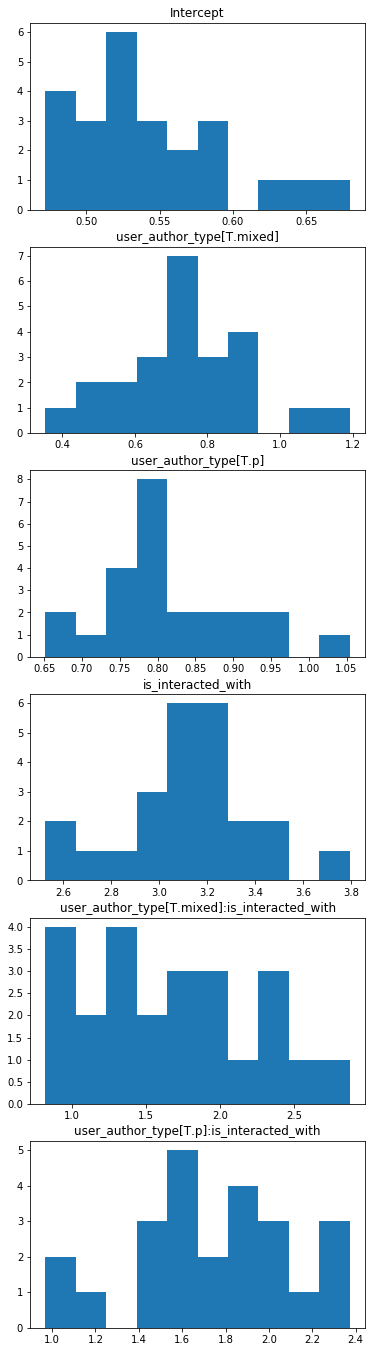

In [184]:
num_params = len(results[0].params)
fig, axs = plt.subplots(nrows=num_params, ncols=1, figsize=(6,24))
for i, ax in enumerate(axs):
    ax.hist(np.exp(params[:,i]))
    ax.set_title(results[0].params.index[i])
plt.show()